# Initial Data Analysis for Human Activity Recognition dataset

Dataset Info: https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones
References blog post:
- http://ataspinar.com/2018/04/04/machine-learning-with-signal-processing-techniques/
- https://towardsdatascience.com/human-activity-recognition-har-tutorial-with-keras-and-core-ml-part-1-8c05e365dfa0
- https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/

In [2]:
# Import neccessary package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 0.  input files and Transforming data into correct shape

In [3]:
import json

df = pd.DataFrame()
with open('AccelerometerData.json') as json_file:
    data = json.load(json_file)
    for key, value in data.items():
        df[key] = value

In [4]:
df.head(10)

,x,y,z
0,6.763846e+10,1.438737,2.245374
1,2.620000e+02,-0.342579,-0.494260
2,2.620000e+02,-0.342579,-0.494260
3,2.270000e+02,-0.410888,-0.992163
4,8.640200e+04,1.682246,-2.709115
5,4.086389e-01,-0.344093,-1.027178
6,1.241056e+12,0.192714,-0.213212
7,4.300000e+01,-0.024648,-0.132305
8,7.075766e+08,-1.181650,0.215036
9,1.100000e+01,0.137710,-0.174066


## 1. Reading input files and Transforming data into correct shape

In [7]:
# Data has already been splotted into train and test set. Write a couple of function to load signals into numpy array
def read_signals(filename):
    '''
    Input: path to file with different signal samples of 1 sensor (each samples is also sampled at a fixed sampling rate (50 Hz) and time window (2.56 s))
    Output: a 2D numpy array of shape (number of samples , number of sampling data point)
    - number of samples: number of singal examples
    - number of sampling data point: window size * sampling rate = 2.56 (s) * 50 (Hz) = 128 points
    '''
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
        data = np.array(data, dtype=np.float32)
    return data

def read_labels(filename):
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(int, activities))
    return np.array(activities)


In [8]:
Input_folder_train = './UCI HAR Dataset/train/Inertial Signals/'
Input_folder_test = './UCI HAR Dataset/test/Inertial Signals/'

Input_files_train = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt']
Input_files_test = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt']

train_signals, test_signals = [], []

for file in Input_files_train:
    signal = read_signals(Input_folder_train + file)
    train_signals.append(signal)
# Transpose the shape of array to (# samples, # sampling point, # signals)
train_signals = np.transpose(np.array(train_signals), (1,2,0))

for file in Input_files_test:
    signal = read_signals(Input_folder_test + file)
    test_signals.append(signal)
# Transpose the shape of array to (# samples, # sampling point, # signals)
test_signals = np.transpose(np.array(test_signals), (1,2,0)) 

LABELFILE_TRAIN = './UCI HAR Dataset/train/y_train.txt'
LABELFILE_TEST = './UCI HAR Dataset/test/y_test.txt'
train_labels = read_labels(LABELFILE_TRAIN)
test_labels = read_labels(LABELFILE_TEST)

## 2. Data Visualization of signals

Let's first visulize the signals

In [9]:
# A dictionary of actvities description
activities_description = {
    1: 'walking',
    2: 'walking upstairs',
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}

In [10]:
# A fucntion to basically get the corresponding x and y value for the signals
def get_values(y_values, T, N, f_s):
    '''
    y_values = values in y axis
    T = spacing between each time steps (= windows size / sampling points) 
    N = total sampling points
    f_s = sampling frequency
    '''
    y_values = y_values
    sample_rate = 1/f_s
    x_values = [sample_rate * kk for kk in range(0, len(y_values))]
    return x_values, y_values

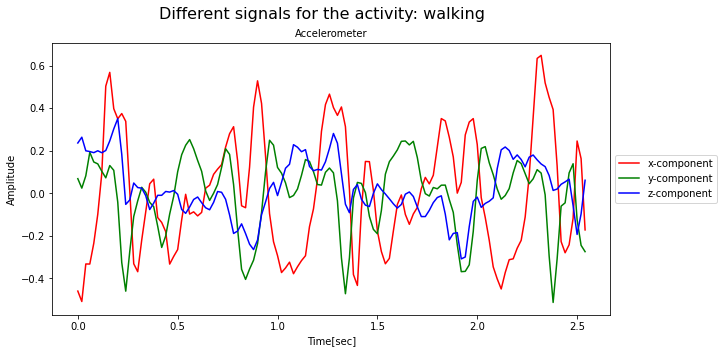

In [17]:
# Inputs for functions. Changing the signal_no variables to sess different samples
N = 128
f_s = 50
t_n = 2.56
T = t_n/N

signal_no = 100
signals = train_signals[signal_no, :, :]
label = train_labels[signal_no]
activity_name = activities_description[label]

# Plot the signal function
labels = ['x-component', 'y-component', 'z-component']
colors = ['r', 'g', 'b']
suptitle = "Different signals for the activity: {}"

xlabel = 'Time[sec]'
ylabel = 'Amplitude'

title = 'Accelerometer'

f = plt.figure(figsize=(10,5))
f.suptitle(suptitle.format(activity_name), fontsize=16)

for comp_no in range(0, train_signals.shape[2]):
    y_values = signals[:, comp_no]
    x_values, y_values = get_values(y_values, T, N, f_s)
    color = colors[comp_no]
    label = labels[comp_no]
    plt.plot(x_values, y_values, linestyle='-', color = color, label = label)

plt.title(title, fontsize=10)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()




It would also be interesting to take a look at the distribution of training example by activity type


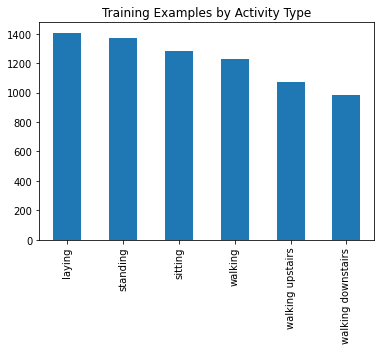

In [45]:
train_label_series = pd.Series(train_labels)
train_label_series = train_label_series.astype('category')
train_label_series = train_label_series.map(activities_description)
train_label_series.value_counts().plot(kind='bar',
                                       title='Training Examples by Activity Type')
plt.show()

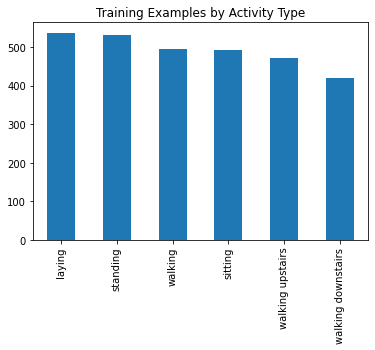

In [46]:
test_label_series = pd.Series(test_labels)
test_label_series = test_label_series.astype('category')
test_label_series = test_label_series.map(activities_description)
test_label_series.value_counts().plot(kind='bar',
                                       title='Training Examples by Activity Type')
plt.show()

Distribution of training and testing data seems well-balanced and similar --> maybe no worried of data leakage

## 3. Model Building

Two different approach has been trying for this problem:
- Approach 1: focus more on feature extractions and feature engineering of signal and then use traditional machine learning algorithm to classfy the actvity
- Approach 2: use more current state of the art deep learning algorithm for sequence model (RNN, LSTM, BirDi RNN,...). Less feature engineering task and focus more on the implementation

--> In a long term, approach 1 seems a little less feasible since it's pretty hard to put into production given the heavy work of preprocessing the data (already have a notebook trying the approach). So, we'll explore different deep learning model in this case. 

--> For this exploratory phase, we'll Keras to get a sense of  a couple of initial result before diving deep into different model tuning techniques. We choose Keras, which is a wrapper for more complex computational engines such as Tensorflow or Theano. We'll go with Tensorflow in this case since it provides more flexibility in terms of later deployment of our model and production phase

In [39]:
# One hot encode the label data to make it a shape of (number of example, number of class)
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, LSTM
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

trainX = train_signals
testX = test_signals
trainY = to_categorical(train_labels)
testY = to_categorical(test_labels)
# Since our class going from 1 to 6, but the to_categorical function in keras always go from 0 to n-classes.
# We're going to delete the first column
trainY = np.delete(trainY, 0, 1)
testY = np.delete(testY, 0, 1)


print("Shape of output in training: {shapeY}".format(shapeY=trainY.shape))
print("Shape of output in testing: {shapeY}".format(shapeY=testY.shape))

Shape of output in training: (7352, 6)
Shape of output in testing: (2947, 6)


In [63]:
# Build a single model
def evaluate_model(trainX, trainY, testX, testY):
    verbose, epochs, batch_size = 1, 50, 1024
    n_timesteps, n_features, n_output = trainX.shape[1], trainX.shape[2], trainY.shape[1]
    model = Sequential()
    model.add(LSTM(150, input_shape=(n_timesteps, n_features)))
    model.add(Dropout(0.3))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_output, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit the network
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.05)
    # evaluate the model
    # _, accuracy = model.evaluate(testX, testY, batch_size=batch_size, verbose=verbose)
    return history


In [64]:
history = evaluate_model(trainX, trainY, testX, testY)

Train on 6984 samples, validate on 368 samples
Epoch 1/50
6984/6984 [==============================] - 15s 2ms/step - loss: 1.7843 - accuracy: 0.2353 - val_loss: 1.7743 - val_accuracy: 0.2473
Epoch 2/50
6984/6984 [==============================] - 15s 2ms/step - loss: 1.7582 - accuracy: 0.2586 - val_loss: 1.7358 - val_accuracy: 0.2255
Epoch 3/50
6984/6984 [==============================] - 16s 2ms/step - loss: 1.6410 - accuracy: 0.3408 - val_loss: 1.5000 - val_accuracy: 0.2935
Epoch 4/50
6984/6984 [==============================] - 16s 2ms/step - loss: 1.3205 - accuracy: 0.3308 - val_loss: 1.1685 - val_accuracy: 0.3668
Epoch 5/50
6984/6984 [==============================] - 22s 3ms/step - loss: 1.1931 - accuracy: 0.3385 - val_loss: 1.2209 - val_accuracy: 0.2962
Epoch 6/50
6984/6984 [==============================] - 21s 3ms/step - loss: 1.1842 - accuracy: 0.3411 - val_loss: 1.1128 - val_accuracy: 0.3859
Epoch 7/50
6984/6984 [==============================] - 19s 3ms/step - loss: 1.2102

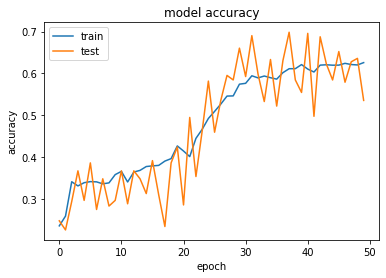

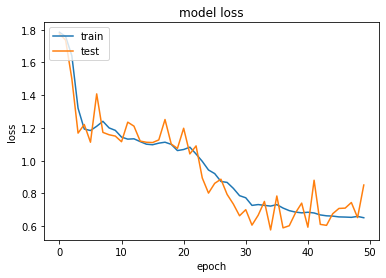

In [66]:
# Plotting training 
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## 4. Model Tuning

For this step, I have already modulerize the above code into certain functions and have a separte python file dedicated to tuning different hyperparmeter, architechture and extra feature engineering. All the experiments, logs and metrics are kept tracked by a very power application call Weight and Biases. For more details of the experiment, please refer to the documentation below:
https://docs.wandb.com/

Notes: I haven't tried out sweep for hyperparameter tuning yet, but it would be super cool to fine tuning your model in a matters of minutes

## 5. Model Evaluation

Our latest model seems doing pretty good with the classification based on the consistency of training and validation accuracy. So, let see how it performs on the test set

Weight and Biases basically saves all our run on the web app as well as the local computer as h5 file. We just need to track the right the location and load it.

In [1]:
# Import neccesary function to load the data set 
from utils.read_data import read_signals, read_labels, load_data
from keras.utils import to_categorical
from keras.models import load_model
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
_, test_signals, _, test_labels = load_data()

In [3]:
testX, testY = test_signals, to_categorical(test_labels)

In [4]:
# Double check the shape
print("Shape of testX {}".format(testX.shape))
print("Shape of testY {}".format(testY.shape))



Shape of testX (2947, 128, 9)
Shape of testY (2947, 7)


In [5]:
# Load the model and make predicition
# best_model.metrics_names to get back the name for each scalar value returned by the list in evaluate


best_model = load_model('wandb/run-20200528_015708-kdj0zy8l/model-best.h5')
score = best_model.evaluate(testX, testY, verbose=1)
print("{} {}".format(best_model.metrics_names[1], score[1]*100))

2947/2947 [==============================] - 3s 1ms/step
accuracy 90.29521346092224


In [6]:
# Make inference with one example
sample = 69
example = testX[sample,:,:].reshape((1,testX.shape[1],testX.shape[2]))
prediction = best_model.predict(example)
prediction_class = prediction.argmax(axis=1)

print("Probabilities for each class: {}".format(prediction))
print("Predicted class with highest probability {}".format(prediction_class))
print("True Class {}".format(testY[sample,:].argmax()))


Probabilities for each class: [[2.3954908e-07 2.3741789e-08 2.8819698e-09 1.6646073e-08 8.0738218e-06
  2.3554827e-08 9.9999166e-01]]
Predicted class with highest probability [6]
True Class 6


In [7]:
# Debug the model with confusion matrix
testY_pred = best_model.predict(testX)

# labels = ['Nothing', 'walking', 'walking upstairs', 'walking downstairs', 'sitting', 'standing', 'laying']
confusion_matrix(testY.argmax(axis=1), testY_pred.argmax(axis=1))


array([[472,   4,  20,   0,   0,   0],
       [ 20, 446,   3,   0,   2,   0],
       [  1,  12, 407,   0,   0,   0],
       [  4,  16,   0, 348, 123,   0],
       [ 10,   0,   0,  44, 478,   0],
       [  0,  27,   0,   0,   0, 510]])

1) There are two things we can observe from the above result:
- Test/dev data accuracy is less than train data accurracy --> maybe overfitting problem. Solutions might be to try out different regularization techniques or collect more data/features

2) Sitting and Standing seems like two really hard things for the model to discern. If you want to improve the perfomance of the RNN model, maybe try:

- Take a look at what features that really helps the model make these decision. From my understanding, the collected sensor data for these these model is a similar.


## 6. Freeze Keras model and prepare to deploy it to tensorflow

One thing to note is that at this time of the analysis, the version of keras and tensorflow to work accordingly with coremltools is:

- keras==2.2.4
- tensorflow==1.1.3

Our training and saving the model session, however, happend with the most updated version of keras and tensorflow. As a result, the configuraton of loading the model in keras version (compatible with coremltools) is slightly different. The resolution is to: 

- Make sure we use the above version for keras and tensorflow
- Modified the saved h5 file (from most updated keras/tensorflow) to a more compatible version for the above keras/tensorflow
- Load the model in normally
- Use coremltools to convert to .mlmodel files compatible for iOS device

In [3]:
# Load in keras model first. Using the older version of keras 
from keras.models import load_model
import h5py

f = h5py.File('wandb/run-20200528_015708-kdj0zy8l/model-best.h5','r+')
data_p = f.attrs['training_config']
data_p = data_p.decode().replace("learning_rate","lr").encode()
f.attrs['training_config'] = data_p
f.close()


<Closed HDF5 file>


In [4]:
best_model = load_model('wandb/run-20200528_015708-kdj0zy8l/model-best.h5')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               70656     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               25800     
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 1407      
Total params: 97,863
Trainable params: 97,863
Non-trainable params: 0
_________________________________________________________________


In [6]:
!pip show tensorflow

Name: tensorflow
Version: 1.14.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/LocNguyen/Desktop/DataSci/human-activity-recognition/HAR/lib/python3.7/site-packages
Requires: astor, keras-preprocessing, termcolor, absl-py, keras-applications, google-pasta, wheel, protobuf, tensorflow-estimator, wrapt, six, numpy, tensorboard, grpcio, gast
Required-by: 


In [7]:
!pip show keras

Name: Keras
Version: 2.2.4
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /Users/LocNguyen/Desktop/DataSci/human-activity-recognition/HAR/lib/python3.7/site-packages
Requires: numpy, keras-preprocessing, h5py, keras-applications, six, scipy, pyyaml
Required-by: 


In [9]:
# Have to load it in from h5 file first and then convert it to mlmodel file
coreml_model = coremltools.converters.keras.convert(best_model, input_names=['sensor_signals'], output_names=['output'])
print(coreml_model)
coreml_model.author = 'Loc Nguyen'
coreml_model.license = 'N/A'
coreml_model.short_description = 'Activity based recognition based on UCI dataset'
coreml_model.output_description['output'] = 'Probability of each activity'


# Save 
coreml_model.save('HARClassifier.mlmodel')

0 : lstm_1_input, <keras.engine.input_layer.InputLayer object at 0x1356184d0>
1 : lstm_1, <keras.layers.recurrent.LSTM object at 0x1356189d0>
2 : dense_1, <keras.layers.core.Dense object at 0x135609e10>
3 : dense_1__activation__, <keras.layers.core.Activation object at 0x138ab39d0>
4 : dense_2, <keras.layers.core.Dense object at 0x135609950>
5 : dense_2__activation__, <keras.layers.core.Activation object at 0x138ab3850>


Recommendation: This model has at least one multiarray input/output of type double.
For large sized arrays, multiarrays of type float32 are more efficient.
In future, float input/output multiarrays will be produced by default by the converter.
Please use, either the flag 'use_float_arraytype' during the call to convert or
the utility 'coremltools.utils.convert_double_to_float_multiarray_type(spec)', post-conversion.


input {
  name: "sensor_signals"
  type {
    multiArrayType {
      shape: 9
      dataType: DOUBLE
    }
  }
}
input {
  name: "lstm_1_h_in"
  type {
